In [8]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
import time

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [6]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    '''
    This function plot confusion matrix method from sklearn package.
    '''

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')

    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):    
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [4]:
data_dir = './Pill Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Invalid Input


In [5]:
class_names = os.listdir(data_dir)
class_names

['Alaxan',
 'Bactidol',
 'Bioflu',
 'Biogesic',
 'DayZinc',
 'Decolgen',
 'Fish Oil',
 'Kremil S',
 'Medicol',
 'Neozep']

In [6]:
class_distribution = [len(os.listdir(data_dir + "/" + name)) for name in class_names]
class_distribution

[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]

In [9]:
fig = px.pie(
    names=class_names,
    values=class_distribution,
    width=500,
    hole=0.2,
    title="Class Distribution"
)
fig.update_layout({'title':{'x':0.5}})
fig.show()

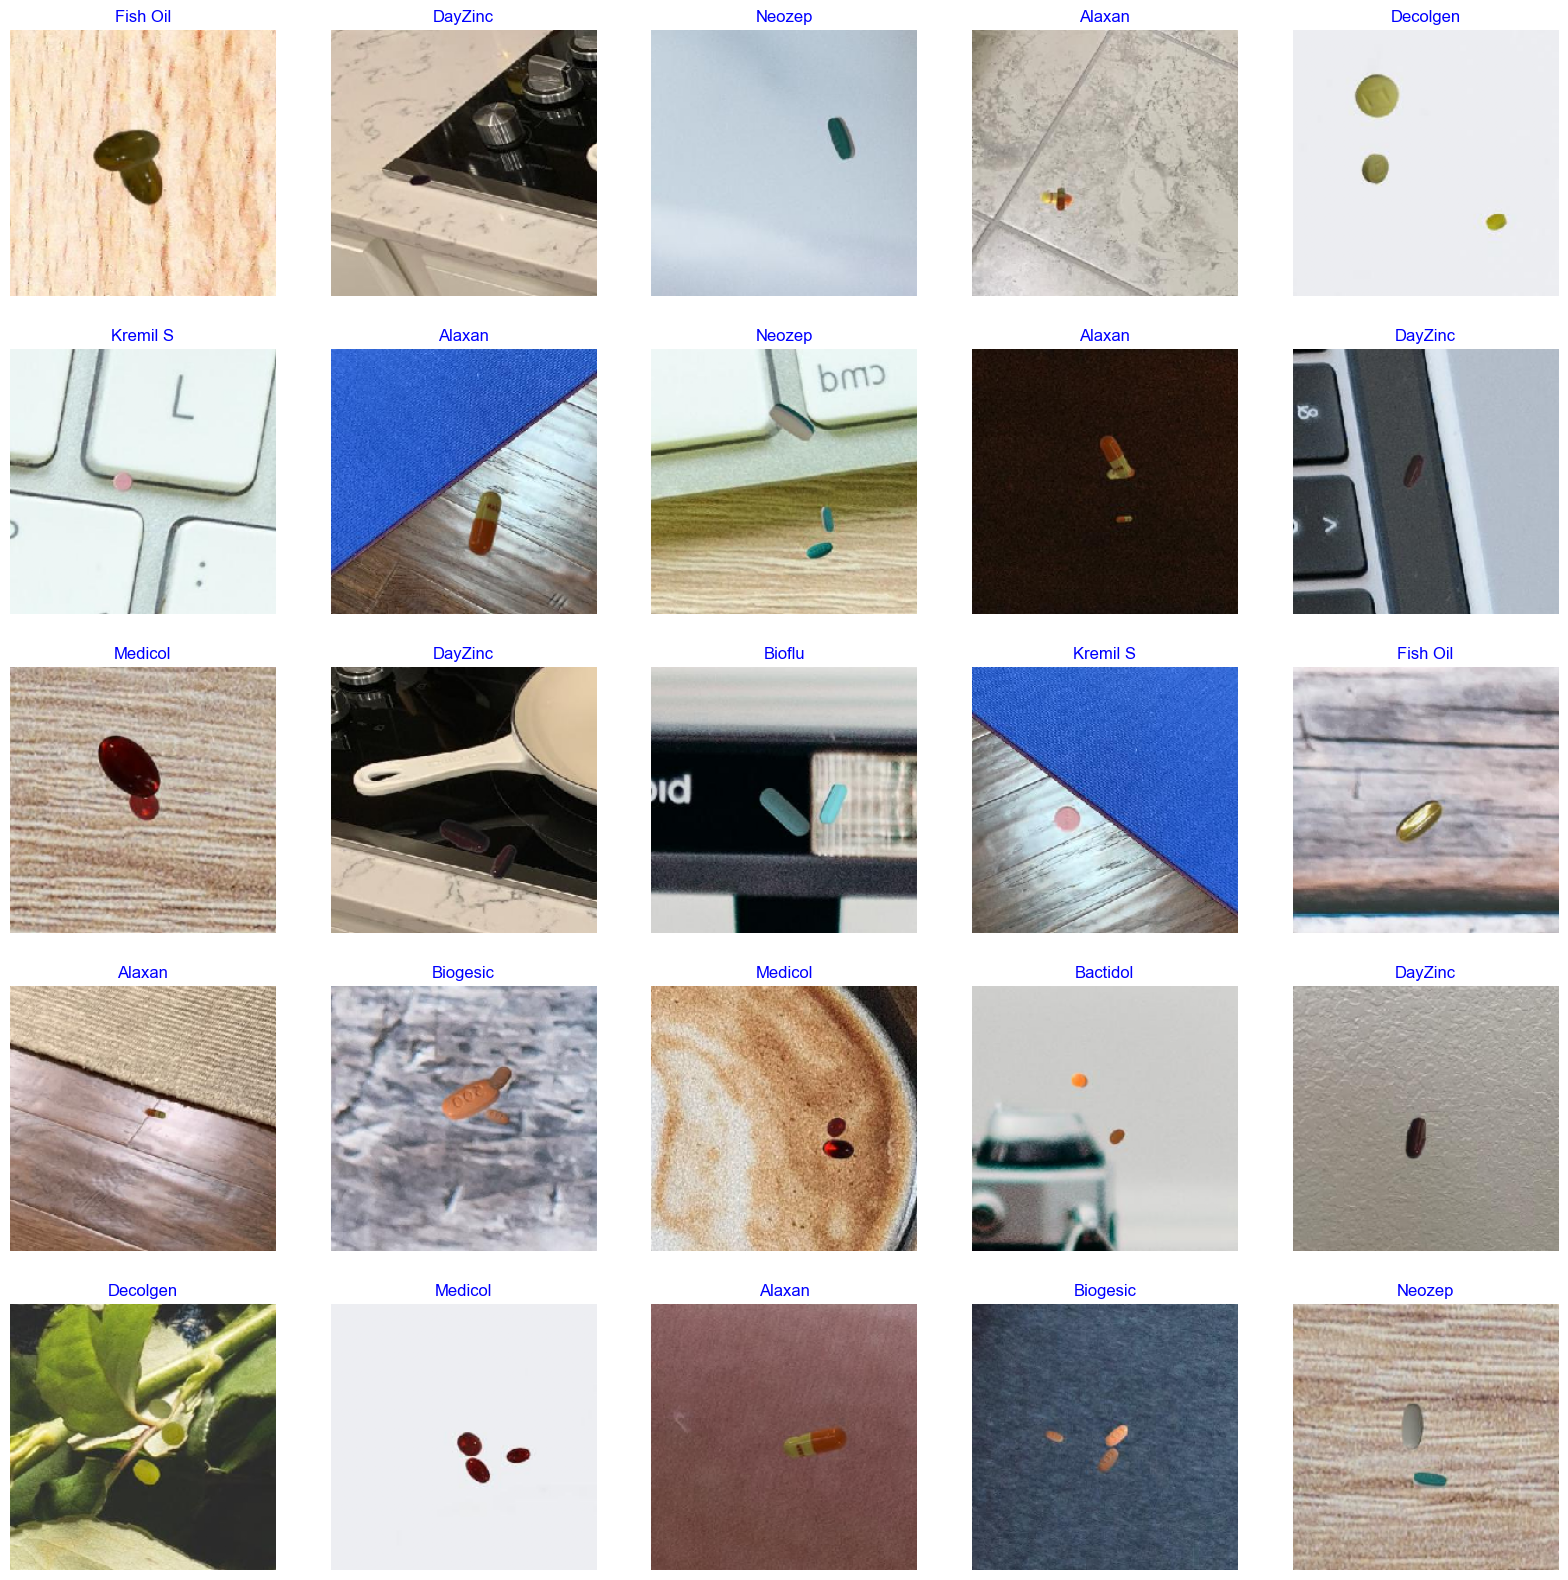

In [9]:
show_images(train_gen)

In [10]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define the number of classes in the dense layer

# create pre-trained model (you can build on a pretrained model such as EfficientNet, VGG, or ResNet)
# we will use EfficientNetB0 from the EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 11,185,721
Trainable params: 11,095,346
Non-trainable params: 90,375
_______________________________________

In [15]:
batch_size = 40  # set batch size for training
epochs = 10  # number of all epochs in training

# Define ReduceLROnPlateau callback
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [16]:
# Record start time
start_time = time.time()

history = model.fit(x=train_gen, epochs=epochs, batch_size=batch_size,
                    validation_data=valid_gen, shuffle=True,
                    callbacks=[lr_callback])

# Record end time
end_time = time.time()

# Calculate training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration} seconds")

Epoch 1/10
200/200 [==============================] - 2414s 12s/step - loss: 5.0558 - accuracy: 0.9616 - val_loss: 3.6822 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - 2372s 12s/step - loss: 2.8149 - accuracy: 0.9879 - val_loss: 2.0221 - val_accuracy: 0.9960 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - 2873s 14s/step - loss: 1.5645 - accuracy: 0.9939 - val_loss: 1.0991 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 4/10
200/200 [==============================] - 2377s 12s/step - loss: 0.8810 - accuracy: 0.9948 - val_loss: 0.6299 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 5/10
200/200 [==============================] - 2365s 12s/step - loss: 0.5361 - accuracy: 0.9956 - val_loss: 0.3817 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
200/200 [==============================] - 2331s 12s/step - loss: 0.3663 - accuracy: 0.9958 - val_loss: 0.2777 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
200/200 [==============================] 

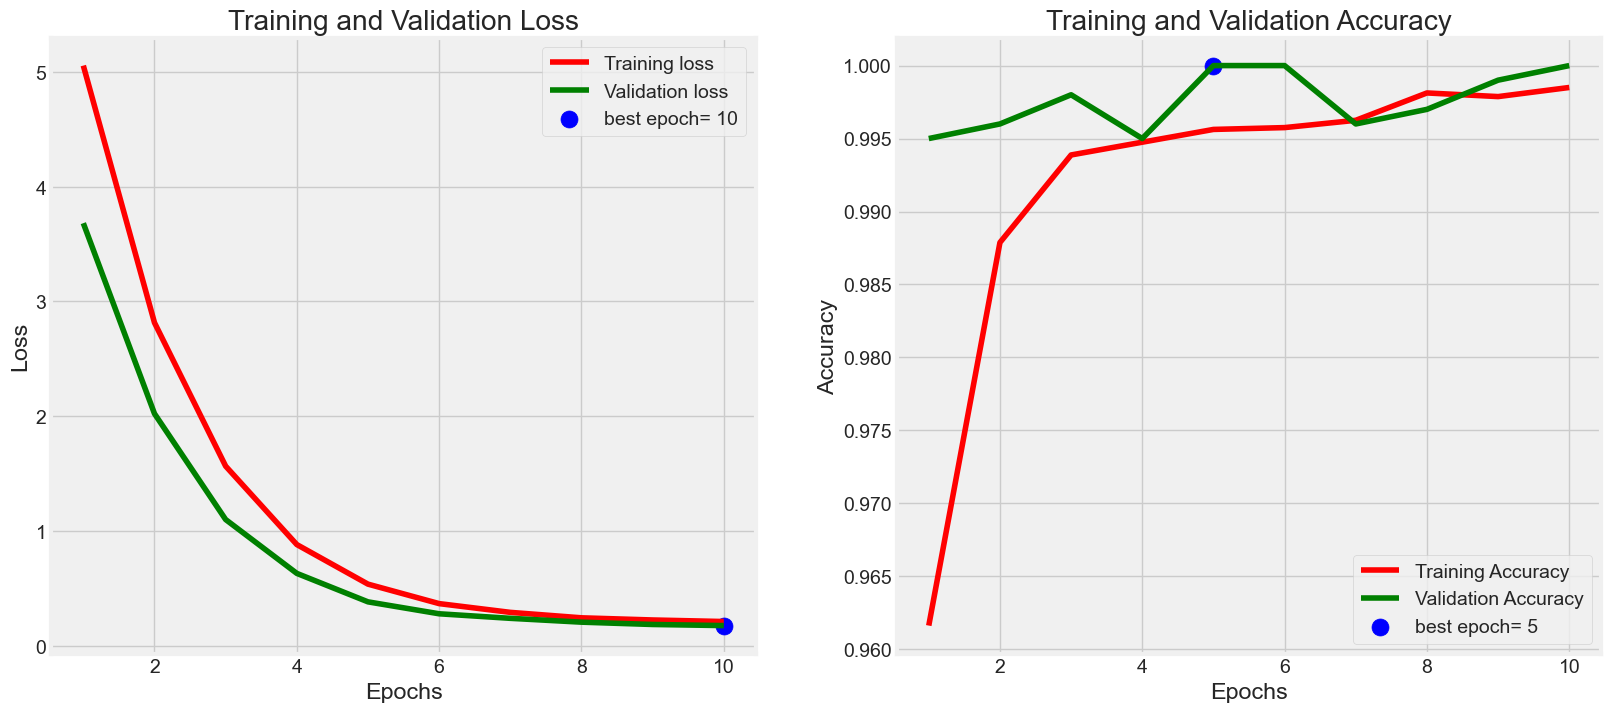

In [17]:
plot_training(history)

In [18]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 58s 3s/step - loss: 0.1764 - accuracy: 0.9990
Train Loss:  0.17515692114830017
Train Accuracy:  1.0
--------------------
Validation Loss:  0.1749219447374344
Validation Accuracy:  1.0
--------------------
Test Loss:  0.17639167606830597
Test Accuracy:  0.9990000128746033


In [19]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[6 7 5 8 2 7 7 9 0 1 3 2 4 1 3 2 1 5 6 0 4 7 4 5 2 7 5 5 0 5 8 5 1 0 9 0 3
 6 8 6 5 9 2 1 2 6 4 1 8 1 4 7 3 7 9 2 1 1 9 3 6 0 3 4 5 2 4 0 6 4 3 8 7 8
 7 4 2 3 7 9 2 3 3 5 4 8 5 9 8 4 1 0 4 8 3 7 9 9 8 1 3 0 8 1 9 7 5 0 4 6 5
 6 4 4 7 9 4 8 0 0 8 5 5 3 2 2 7 1 1 8 6 2 6 5 9 8 8 0 5 8 0 8 0 0 4 9 5 6
 4 8 2 7 4 3 6 5 1 8 9 9 6 9 7 5 7 5 5 1 8 3 5 5 8 4 8 6 9 4 5 1 1 7 3 1 8
 7 1 3 9 6 2 0 6 6 2 0 7 4 7 4 5 3 9 6 7 4 5 6 2 5 7 0 7 1 5 5 6 4 7 2 2 9
 6 5 2 6 8 8 8 2 9 4 4 2 3 7 4 4 0 4 0 4 5 5 6 7 0 1 0 3 2 1 4 9 1 1 4 4 7
 6 2 4 7 8 3 4 6 3 5 0 6 7 7 6 9 9 3 3 6 1 0 4 7 1 3 5 8 5 0 5 0 4 1 2 5 5
 3 8 0 5 2 5 3 5 2 0 5 5 9 6 8 9 9 1 2 1 8 5 0 1 2 4 6 0 2 5 0 5 1 3 0 8 1
 4 9 0 3 9 1 9 6 9 6 4 4 3 5 5 7 2 2 1 3 9 8 3 5 2 2 7 2 7 4 8 4 8 1 8 9 1
 9 9 5 4 0 1 1 7 0 9 3 0 3 7 2 8 0 3 5 3 7 7 9 7 4 8 0 4 5 2 2 9 5 4 6 2 0
 8 4 9 8 5 0 7 2 9 1 7 9 9 9 2 4 3 0 0 0 4 1 0 9 9 1 4 2 4 6 9 4 9 3 5 0 5
 5 9 0 2 2 0 5 2 8 7 0 1 8 2 5 3 7 5 1 3 2 3 2 7 7 7 6 0 4 2 2 8 7 2 9 3 9
 8 3 6 3 1 4 5 2 4 9 4 2 

Confusion Matrix, Without Normalization
[[100   0   0   0   0   0   0   0   0   0]
 [  0  99   0   1   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0]
 [  0   0   0   0   0 100   0   0   0   0]
 [  0   0   0   0   0   0 100   0   0   0]
 [  0   0   0   0   0   0   0 100   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   0   0   0   0   0 100]]
              precision    recall  f1-score   support

      Alaxan       1.00      1.00      1.00       100
    Bactidol       1.00      0.99      0.99       100
      Bioflu       1.00      1.00      1.00       100
    Biogesic       0.99      1.00      1.00       100
     DayZinc       1.00      1.00      1.00       100
    Decolgen       1.00      1.00      1.00       100
    Fish Oil       1.00      1.00      1.00       100
    Kremil S       1.00      1.00      1.00       100
     Medicol       1.00      1.00      1.0

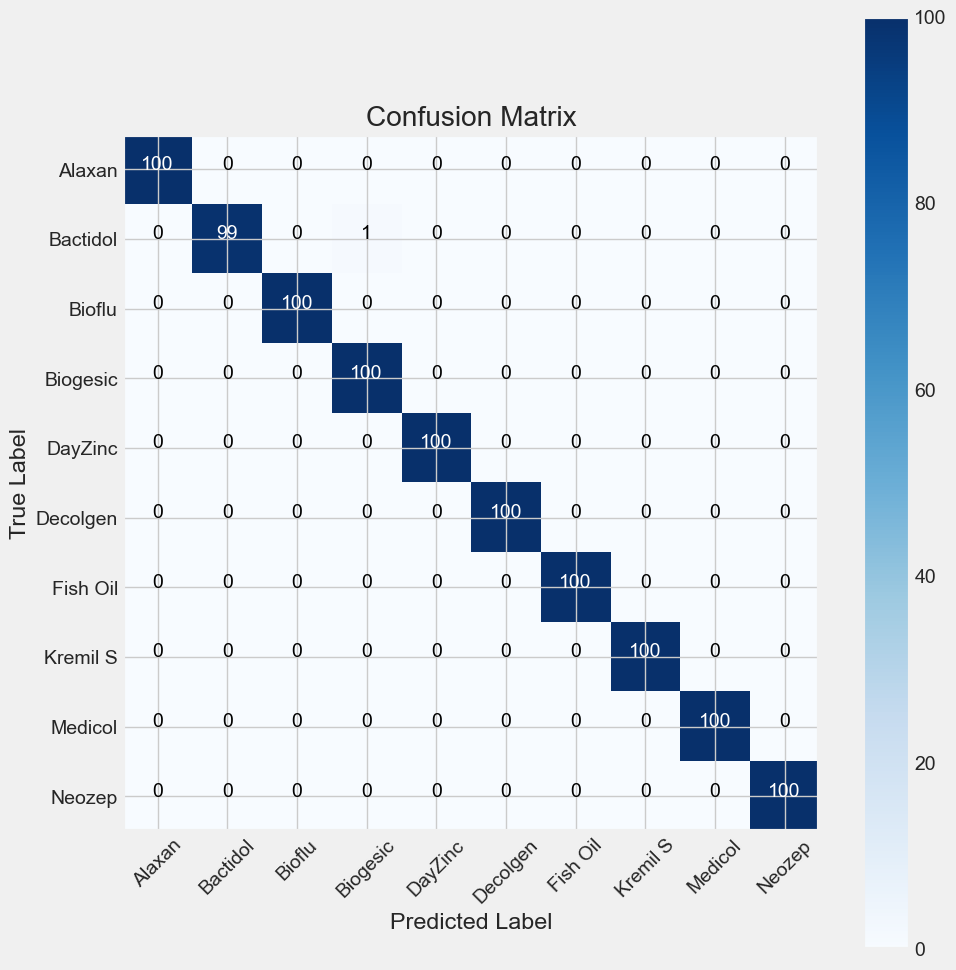

In [20]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))